<center><h1>Universidad Politecnica Salesiana</h1></center>
<center><h2>Sympy parte 1</h2></center>
<center><h3>Marcela Zhagui</h3></center>

# Entornos de soporte al desarrollo de simulaciones: Simpy - Parte 1

In [17]:
import simpy
import random
import matplotlib.pyplot as pp

%matplotlib inline


## Práctica  - SimPy 

- Investigar el proceso de atencion de un paciente diagnosticado con COVID-19, ademas de tiempos de atencion, recursos necesarios y tipos de pacientes.
- Investigar en cada una de las provincias asignadas el numero de hospitales, camas, respiradores y personal medico, limpieza y enfermeria.
- Finalmente el costo de atender a un paciente con COVID-19 y medicamentos.


In [48]:
# NUM HOSPUTALES
NUM_HOSPITALES = 2
#Numero de camas
NUM_CAMAS=412;
# maximo de pacientes por dia 
MAX_PACIENTES = 465
# Tiempo que tarda en atenderse un paciente (minutos)
TIEMPO_ATENCION = 15
# Intervalo de tiempo en que llegan pacientes(minutos)
INTERVALO_LLEGADA = 5
# Tiempo de simulación
TIEMPO_SIMULACION = 200

#DICCIONARIOS
tiempo={}
Pacientes_llegan={}
Pno={}

class Hospital(object):
    
    def __init__(self, environment, num_hospitales, tiempo_atencion, camas):
        # Guardamos como variable el entorno de ejecucion
        self.env=environment
        # Creamos el recurso que representa los consultorios
        self.consultorios = simpy.Resource(environment, num_hospitales)
        
        self.camas = simpy.Resource(environment, camas)
        # Variable para el tiempo de atencion 
        self.tiempo_atencion = tiempo_atencion
        
    def atencion(self, paciente):
        yield self.env.timeout(random.randint(TIEMPO_ATENCION-2, TIEMPO_ATENCION+2))   
        print(chr(27)+"[0;30m"+paciente,' Atendido')
        
    def zona_aislamiento(self, paciente):
        t=random.randint(5, 20)
        rnd = random.randint(1,100)
        #8% de probabilidad de fallecer
        #92% de probabilidad de cura 
        if rnd <= 90:
            yield self.env.timeout(t)
            print(chr(27)+"[0;33m"+'El ',paciente, 'Termina la Hospitalizacion en', t ,' Dias')
        else:
            yield self.env.timeout(t)
            print(chr(27)+"[1;30m"+'El ', paciente, 'Fallece a', t ,' Dias de Hospitalizacion')
        
        tiempo[paciente]=t
        
    
def llegada_paciente(env, nombre, hospital):
    # Usamos el reloj de la simulacion (env.now()) para indicar a la
    # hora que llega el paciente con el nombre pasado como parametro
    print(chr(27)+"[0;30m"+'Llega paciente: %s a la hora %.2f.' % (nombre, (env.now+420)/60))
    Pacientes_llegan[nombre]=((env.now+420)/60)
    
    # Especificamos que vamos a usar un recurso (Resource) que representa
    # el consultorio del Hospital
    with hospital.consultorios.request() as consultorio:
        yield consultorio
        # Indicamos que el paciente entra al consultorio
        print(chr(27)+"[0;30m"+'Entra paciente a atenderce: %s a la hora %.2f.' % (nombre, (env.now+420)/60))
        
        # se realiza el test de covid_19
        
        rnd = random.randint(1,100)
        if rnd <= 59: # sanos 59% infectados 41%
            yield env.process(hospital.atencion(nombre))
            print(chr(27)+"[0;32m"+'Paciente Sano [%s] Atendido a las %.2f.' % (nombre, (env.now+420)/60),"Casa")
            tiempo[nombre]=((env.now+420)/60)
            
        else:
            yield env.process(hospital.atencion(nombre))
            print(chr(27)+"[0;31m"+'Paciente Infectado [%s] Atendido a las %.2f.' % (nombre, (env.now+420)/60),"Internado")
            with hospital.camas.request() as cama:
                # Ocupamos el consultorio
                yield cama
                # Indicamos que paciente entra al consultorio
                print('se le asigna a una cama: %s a la hora %.2f.' % (nombre, (env.now+420)/60))
                yield env.process(hospital.zona_aislamiento(nombre))     
        
    
def ejecutar(env, num_hospitales, tiempo_atencion, intervalo,camas):
    hospital=Hospital(env, num_hospitales, tiempo_atencion, camas)
    # Creamos 5 llegadas de pacientes iniciales
    for i in range(5):
        env.process(llegada_paciente(env, 'Paciente-%d'%(i+1),hospital))
    
    # Ejecutamos la simulacion
    while True:
        yield env.timeout(random.randint(intervalo-3, intervalo+3))
        i+=1
        # Mientras se atienden los pacientes generamos mas pacientes
        env.process(llegada_paciente(env,'Paciente-%d'%(i+1),hospital))

print('Hospital')
# Creamos el entorno de simulacion
env=simpy.Environment()
env.process(ejecutar_simulacion(env, NUM_HOSPITALES, TIEMPO_ATENCION, INTERVALO_LLEGADA, NUM_CAMAS))

# Ejecutamos el proceso durante el tiempo de simulacion
env.run(until = TIEMPO_SIMULACION)
print("\n")
print(chr(27)+"[0;34m"+"Numero de pacientes :",len(Pacientes_llegan))
print(chr(27)+"[0;34m"+"Numero de pacientes Atendidos:",len(tiempo))
print(chr(27)+"[0;34m"+"Numero de pacientes se quedaron sin atender y fallecieron:",len(Pacientes_llegan)-len(tiempo))


Hospital
Llega paciente: Paciente-1 a la hora 7.00.
Llega paciente: Paciente-2 a la hora 7.00.
Llega paciente: Paciente-3 a la hora 7.00.
Llega paciente: Paciente-4 a la hora 7.00.
Llega paciente: Paciente-5 a la hora 7.00.
Entra paciente a atenderce: Paciente-1 a la hora 7.00.
Entra paciente a atenderce: Paciente-2 a la hora 7.00.
Llega paciente: Paciente-6 a la hora 7.07.
Llega paciente: Paciente-7 a la hora 7.15.
Paciente-1  Atendido
Paciente-2  Atendido
Paciente Infectado [Paciente-1] Atendido a las 7.22. Internado
Paciente Sano [Paciente-2] Atendido a las 7.22. Casa
se le asigna a una cama: Paciente-1 a la hora 7.22.
Entra paciente a atenderce: Paciente-3 a la hora 7.22.
Llega paciente: Paciente-8 a la hora 7.25.
Llega paciente: Paciente-9 a la hora 7.37.
Llega paciente: Paciente-10 a la hora 7.42.
Paciente-3  Atendido
Paciente Sano [Paciente-3] Atendido a las 7.47. Casa
Entra paciente a atenderce: Paciente-4 a la hora 7.47.
Llega paciente: Paciente-11 a la hora 7.53.
El  Paciente

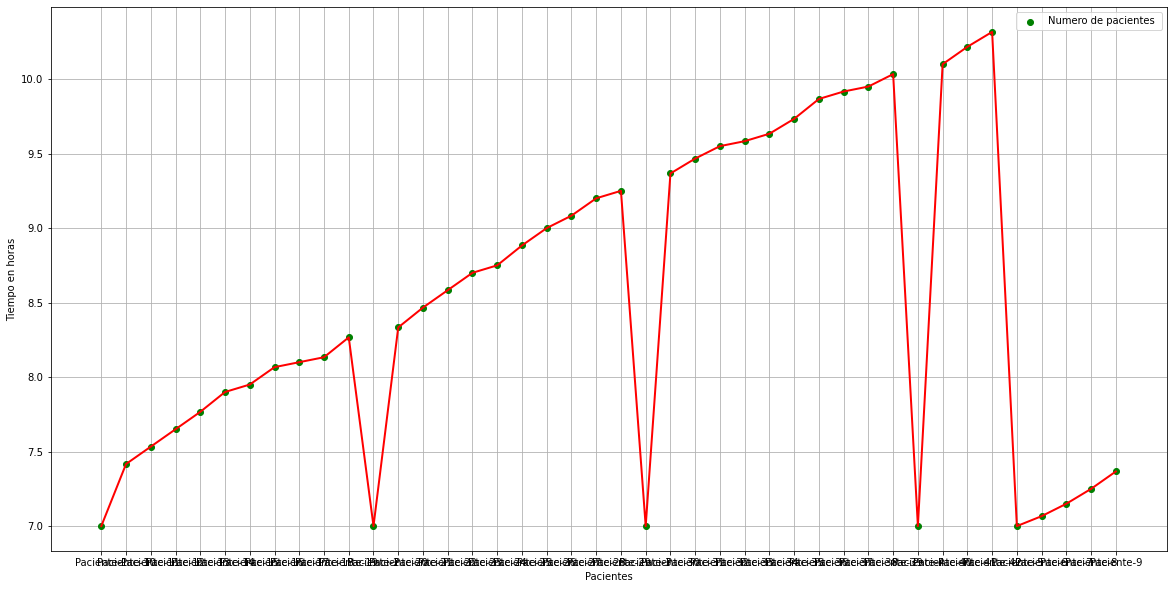

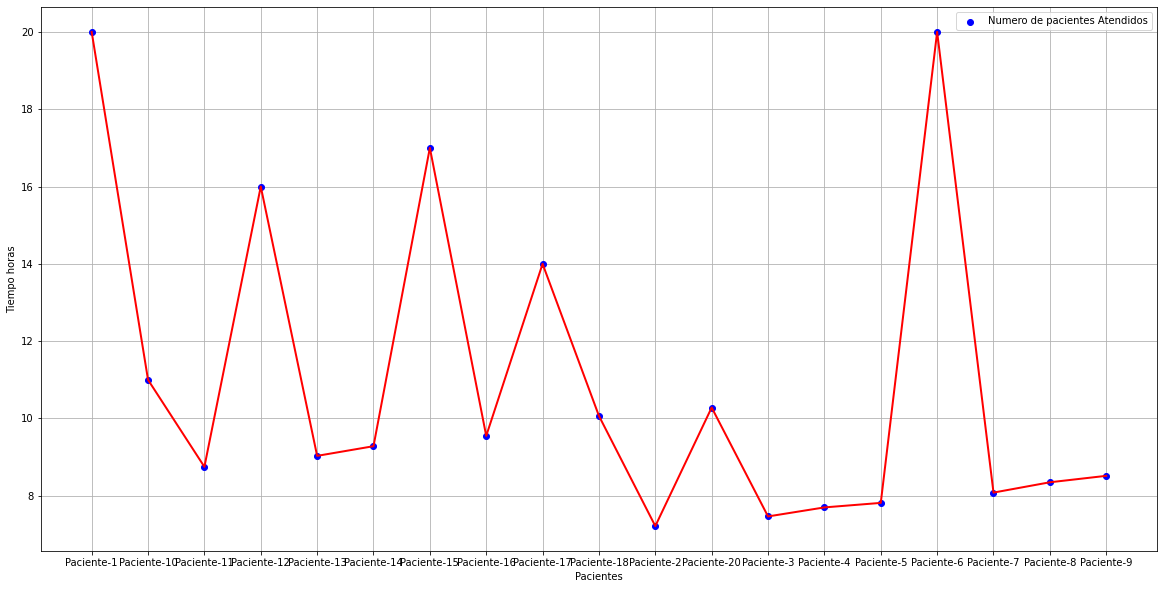

In [51]:
datos=sorted(tiempo.items())
datos2=sorted(Pacientes_llegan.items())
x, y =zip(*datos)
x2, y2 =zip(*datos2)

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111,  axisbelow=True)


ax.plot(x2,y2,linewidth=2,color='red')
ax.scatter(x2,y2,color='g',label='Numero de pacientes ')


ax.set_xlabel('Pacientes')
ax.set_ylabel('Tiempo en horas')
legend = ax.legend()
ax.grid(True)

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111,  axisbelow=True)


ax.plot(x,y,linewidth=2,color='red')
ax.scatter(x,y,color='b',label='Numero de pacientes Atendidos')

ax.set_xlabel('Pacientes')
ax.set_ylabel('Tiempo horas')
legend = ax.legend()
ax.grid(True)


## Referencias
[1] Matloff, N. (2008). Introduction to Discrete-Event Simulation and the SimPy Language.

[2] Team Simpy (2017). SimPy Documentation, Release 3.0.10, 2017. URL: https://media.readthedocs.org/pdf/simpy/latest/simpy.pdf 